In [22]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample.geometry import GridDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
sys.path.append('../saildrone/subroutines/')
import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob

In [266]:
files2

['z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/004\\20190104023913-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r35278-v02.0-fv01.0.nc',
 'z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/004\\20190104010020-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r35277-v02.0-fv01.0.nc',
 'z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/004\\20190104055658-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r35280-v02.0-fv01.0.nc',
 'z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/004\\20190104190804-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_v08_r35288-v02.0-fv01.0.nc',
 'z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/004\\20190104105339-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_v08_r35283-v02.0-fv01.0.nc',
 'z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/004\\20190104123232-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_v08_r35284-v02.0-fv01.0.nc',
 'z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/004\\20190104172911-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_v08_r35287-v02.0-fv01.0.nc',
 'z:/allD

In [267]:
fname = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2020/001/20200101013834-REMSS-L2P_GHRSST-SSTsubskin-AMSR2-L2B_rt_r40549-v02.0-fv01.0.nc'
files = glob('z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/001/*.nc')
for idy in range(2,5):
    files2 = glob('z:/allData/ghrsst/data/GDS2/L2P/AMSR2/REMSS/v8a/2019/'+str(idy).zfill(3)+'/*.nc')
    for f in files2:
        if '_v08_' in f:
            files.append(f)
adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
print(len(files))
#files

58


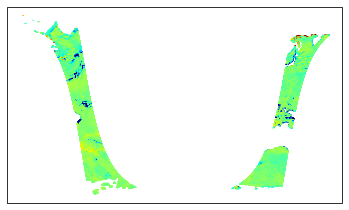

In [120]:
adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
fname = adir + files[0][2:]
fname=fname.replace('\\','/')
fname
ds = xr.open_dataset(fname)
gattrs = {"units": "seconds since "+str(ds.time[0].data)}
ds2 = ds
ds2.sst_dtime.attrs = gattrs
ds2 = xr.decode_cf(ds2)

x = ds.lon.data
y = ds.lat.data
z = ds.dt_analysis.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')


In [257]:
len(files)

18

In [ ]:
for dw in range(31,51,2):
    ordered_files = []
    for ifile in range(len(files)):
        adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
        fname = adir + files[ifile][2:]
        fname=fname.replace('\\','/')
        ds = xr.open_dataset(fname)
        ds.close()
        ordered_files.append(ds.time.data)
    iarg = np.argsort(ordered_files,axis=0)

    da2 = xr.DataArray(np.zeros((1800,3600)),name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3 = xr.DataArray(np.ones((1800,3600))*99999999,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    dt = -99
    for ifile in iarg:
        adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
        tem_file = files[ifile[0]]
        #print(tem_file)
        fname = adir + tem_file[2:]
        fname=fname.replace('\\','/')
        ds = xr.open_dataset(fname)
        ds = ds.isel(ni=slice(121-dw,122+dw))
        #print(ds.time.data)
        if dt==-99:
            start_time = ds.time
            dt = (ds.time[0] - ds.time[0])/np.timedelta64(1,'s')
        else:
            dt = (ds.time[0] - start_time)/np.timedelta64(1,'s')
        print(ifile,dt.data)
        x = ds['lon'].fillna(-89).data 
        y = ds['lat'].fillna(-89).data 
        z = ds['sst_dtime'].data + int(dt)
        lons,lats,data = x,y,z 
        swath_def = SwathDefinition(lons, lats)
        grid_def_lons, grid_def_lats = np.arange(-180,180,0.1), np.arange(-90,90,0.1)
        grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

        # Since we have the lon and lat values for the area, we define a grid instead of an area:
        # https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
        grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

        result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
        da = xr.DataArray(result1,name='sec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
        daeq = da.sel(lat=0,method='nearest')
        swidth = len(daeq.where(daeq>0,drop=True))*10/2
        dif = da - da2
        dif = np.where(da2>0,dif,999999)
        da3 = np.where(dif<da3,dif,da3)
        da2 = np.where(da>da2,da,da2)
        da2 = xr.DataArray(da2,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3 = xr.DataArray(da3,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da3.to_netcdf('C:/Users/gentemann/Google Drive/f_drive/docs/proposals/nasa/EVM/JPL_EVM3/data/full_width'+str(swidth)+'.nc')

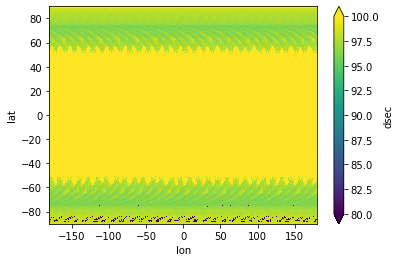

In [275]:
(da3/60).plot(vmin=80,vmax=100)

In [294]:
#how to calculate swath width
for dw in range(31,51,2):
    ds = xr.open_dataset(fname)
    ds = ds.isel(ni=slice(121-dw,122+dw))
    #print(ds.time.data)
    if dt==-99:
        start_time = ds.time
        dt = (ds.time[0] - ds.time[0])/np.timedelta64(1,'s')
    else:
        dt = (ds.time[0] - start_time)/np.timedelta64(1,'s')
    #print(ifile,dt.data)
    x = ds['lon'].fillna(-89).data 
    y = ds['lat'].fillna(-89).data 
    z = ds['sst_dtime'].data + int(dt)
    lons,lats,data = x,y,z 
    swath_def = SwathDefinition(lons, lats)
    grid_def_lons, grid_def_lats = np.arange(-180,180,0.1), np.arange(-90,90,0.1)
    grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

    # Since we have the lon and lat values for the area, we define a grid instead of an area:
    # https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
    grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)
    result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
    da = xr.DataArray(result1,name='sec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))
    da2 = da.sel(lat=0,method='nearest')
    print(dw,'swath width',len(da2.where(da2>0,drop=True))*10/2)

21 swath width 380.0
26 swath width 460.0
31 swath width 535.0
36 swath width 615.0
41 swath width 690.0
46 swath width 765.0


In [291]:
dw = 121
tem = ds.isel(ni=slice(121-dw,122+dw))
tem

<xarray.Dataset>
Dimensions:                  (ni: 243, nj: 4194, time: 1)
Coordinates:
    lat                      (nj, ni) float32 ...
    lon                      (nj, ni) float32 ...
  * time                     (time) datetime64[ns] 2019-01-04T22:25:50
Dimensions without coordinates: ni, nj
Data variables:
    sea_surface_temperature  (time, nj, ni) float32 ...
    sst_dtime                (time, nj, ni) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dt_analysis              (time, nj, ni) float32 ...
    sses_bias                (time, nj, ni) float32 ...
    sses_standard_deviation  (time, nj, ni) float32 ...
    l2p_flags                (time, nj, ni) int16 ...
    quality_level            (time, nj, ni) float32 ...
    wind_speed               (time, nj, ni) float32 ...
    diurnal_amplitude        (time, nj, ni) float32 ...
    cool_skin                (time, nj, ni) float32 ...
    water_vapor              (time, nj, ni) float32 ...
    cloud_liquid_water       (time, nj, ni) float32 ...
    rain_rate                (time, nj, ni) float32 ...
Attributes:
    Conventions:                CF-1.6, Unidata Observation Dataset v1.0
    title:                      Sea Surface Temperature from AMSR2 onboard GC...
    summary:                    Sea Surface Temperature from AMSR2 onboard GC...
    comment:                    This research was supported by the NASA Physi...
    references:                 MW SSES Report version 3.0
    institution:                REMSS
    gds_version_id:             2.0
    netcdf_version_id:          4.4
    date_created:               20190106T002533Z
    uuid:                       b1d84685-2dee-4d25-878b-871a583899b5
    history:                    created with ghrsst_swath_processor processing
    license:                    Free and open
    id:                         AMSR2-REMSS-L2P-v8a
    naming_authority:           org.ghrsst
    product_version:            v8a
    file_quality_level:         3
    spatial_resolution:         25 km
    start_time:                 20190104T222550Z
    stop_time:                  20190105T000442Z
    time_coverage_start:        20190104T222550Z
    time_coverage_end:          20190105T000442Z
    southernmost_latitude:      -89.35
    northernmost_latitude:      89.13
    westernmost_longitude:      -179.99
    easternmost_longitude:      180.0
    source:                     REMSS AMSR2 L2B Version-8
    platform:                   GCOM-W1
    sensor:                     AMSR2
    Metadata_Conventions:       Unidata Dataset Discovery V1.0
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    acknowledgment:             http://www.remss.com/missions/amsr
    creator_name:               Remote Sensing Systems
    creator_email:              support@remss.com
    creator_url:                www.remss.com
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath

In [225]:
for ifile in range(2):
    adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
    inum = np.where(iarg==ifile)
    tem_file = files[int(inum[0])]
    print(int(inum[0]),tem_file,ordered_files[int(inum[0])])

ValueError: applied function returned data with unexpected number of dimensions. Received 3 dimension(s) but expected 0 dimensions with names: ()

In [161]:
(ds.time[0]-start_time[0])/np.timedelta64(1,'m')

<xarray.DataArray 'time' ()>
array(-791.08333333)

In [140]:
da2 = xr.DataArray(np.zeros((1800,3600)),name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))

for ifile in range(2):
    adir = 'https://podaac-opendap.jpl.nasa.gov/opendap/'
    fname = adir + files[ifile][2:]
    fname=fname.replace('\\','/')
    ds = xr.open_dataset(fname)


gattrs = {"units": "seconds since "+str(ds.time[0].data)}
ds.sst_dtime.attrs = gattrs
ds2 = xr.decode_cf(ds)
x = ds['lon'].fillna(-89).data 
y = ds['lat'].fillna(-89).data 
z = ds['sst_dtime'].data 
lons,lats,data = x,y,z 
swath_def = SwathDefinition(lons, lats)
grid_def_lons, grid_def_lats = np.arange(-180,180,0.1), np.arange(-90,90,0.1)
grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

# Since we have the lon and lat values for the area, we define a grid instead of an area:
# https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
da = xr.DataArray(result1,name='sec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))

da2 = np.where(da>da2,da,da2)
da2 = xr.DataArray(da2,name='dsec',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))


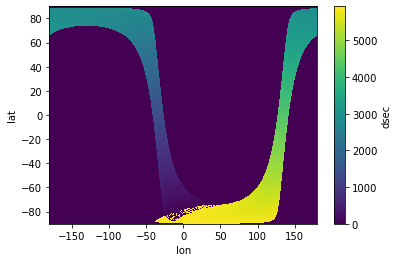

In [146]:
da2.plot()